In [1]:
import numpy as np
from matplotlib import pyplot as plt
import lineax as lx
import diffrax
import equinox as eqx
from jax import numpy as jnp, jit

# We'll need this dummy stepper
class Stepper(diffrax.Euler):
    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        del solver_state, made_jump
        y1 = terms.vf(t0, y0, args)
        dense_info = dict(y0=y0, y1=y1)
        return y1, None, dense_info, None, diffrax.RESULTS.successful


In [2]:
def get_analytical_1d(diff_coeff, t, ax):
    """
    Returns the analytical solution of the diffusion equation to a normalized gaussian initial condition
    
    We use this to generate the initial condition, $t=1000$ and solution at a later time, $t > 1000$
    
    Args: 
    diff_coeff: diffusion coefficient
    t: time
    ax: axis
    
    Returns:
    solution array at time t that is (ax.size, ) in shape
    
    """
    
    return 1/np.sqrt(4*np.pi*diff_coeff*t)*np.exp(-ax**2./4/diff_coeff/t)

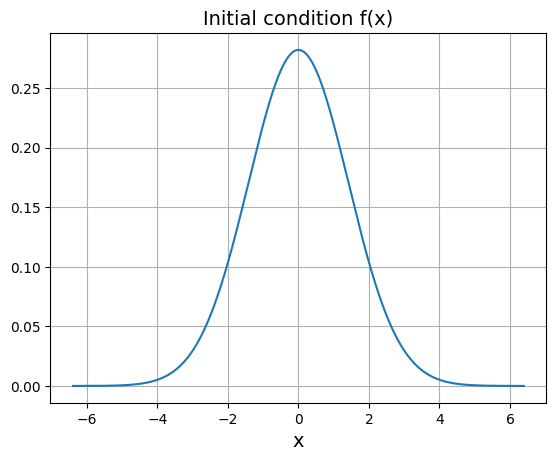

In [3]:
nv = 2048
vmax = 6.4
dv = 2*vmax/nv

v = np.linspace(-vmax+dv/2., vmax-dv/2., nv)
plt.plot(v, get_analytical_1d(0.001, 1000, v))
plt.title("Initial condition f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.grid()

In [4]:
def solve_diff_1d(dt, finp, diff_coeff):
    """
    Solves 1 diffusion timestep
    
    NB: v is hardcoded here because of global variables in Jupyter Notebooks.
    Do not do this in a production environment 
    
    Args:
    dt: timestep
    finp: input array
    diff_coeff: diffusion coefficient
    
    Returns:
    solution to the diffusion equation
    
    """
    coeff = -dt * diff_coeff / dv**2.
    diag = 1-np.concatenate([[1.], 2*np.ones_like(v[1:-1]), [1.]])*coeff
    lower_diag = np.ones_like(v[1:])*coeff
    upper_diag = np.ones_like(v[1:])*coeff
    operator = lx.TridiagonalLinearOperator(diag, lower_diag, upper_diag)
    solution = lx.linear_solve(operator, finp, solver=lx.Tridiagonal())
    return solution.value

class VectorField(eqx.Module):
    """
    This function returns the function that defines $d_state / dt$

    All the pushers are chosen and initialized here and a single time-step is defined here.

    We use the time-integrators provided by diffrax, and therefore, only need $d_state / dt$ here

    :param cfg:
    :return:
    """
    v: jnp.ndarray
    dt: float
    kappa: float
    
    def __init__(self, v: jnp.ndarray, dt: float, kappa: float):
        super().__init__()
        self.v = v
        self.dt = dt
        self.kappa = kappa

    def __call__(self, t: float, y: jnp.ndarray, args):
        return solve_diff_1d(self.dt, y, self.kappa)

In [5]:
tmax = 1800
dt = 0.1
kappa = 0.001
t0 = 1000
nt = int((tmax-t0)/dt + 1)
val0 = get_analytical_1d(kappa, t0, v)

In [6]:
from time import time
_t0_ = time()
val = np.copy(val0)

def _run_(_val_):
    for i in range(nt):
        _val_ = solve_diff_1d(dt, _val_, kappa)
    return _val_

_run_(val)
    
print(f"{round(time() - _t0_, 3)} s")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


13.872 s


In [7]:
_t0_ = time()
result = diffrax.diffeqsolve(terms=diffrax.ODETerm(VectorField(v, dt, kappa)), solver=Stepper(), max_steps=int(1e9), t0=t0, t1=tmax, dt0=dt, y0=jnp.array(val0), saveat=diffrax.SaveAt(ts=np.linspace(t0, tmax, 101)))
print(f"{round(time() - _t0_, 3)} s")

1.447 s


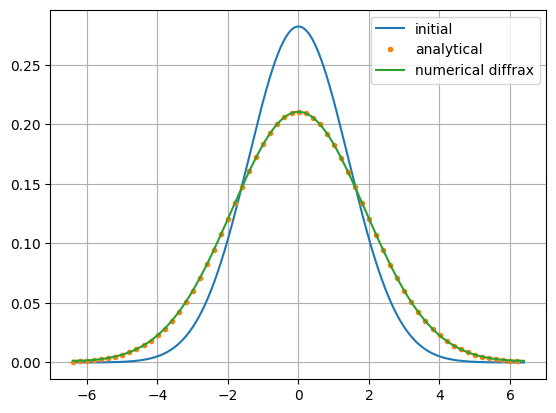

In [8]:
val = get_analytical_1d(0.001, nt*dt+1000, v)
plt.plot(v, val0, label="initial")
plt.plot(v[::32], val[::32], ".", label="analytical")
# plt.plot(v, val, label="numerical")
plt.plot(v, result.ys[-1], label="numerical diffrax")
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Error')

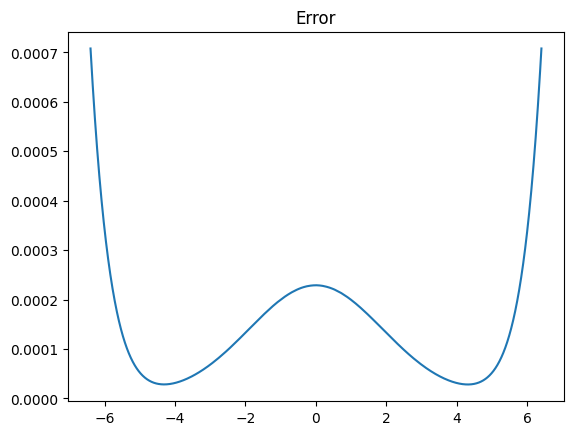

In [9]:
plt.plot(v, result.ys[-1] - val)
plt.title("Error")

In [16]:
result.ys[-1].shape

(2048,)

In [24]:
np.testing.assert_array_almost_equal(result.ys[-1], val, decimal=3)